 Vehicle Type Classification using Convolutional Neural Network
===

## **Contents**
- [Vehicle Type Classification using Convolutional Neural Network](#Project Overview)
  - [Project Overview](#Project-Overview)
    - [General Information](#General-Information)
    - [Dataset Introduction](#Dataset-Introduction)
    - [Set Up Deep Learning Environment](#Set-Up-Deep-Learning-Environment)
  - [Project Implementation](#Project-Implementation)
    - [Data Preprocessing](#Data-Preprocessing)
    - [Baseline CNN model](#Baseline-CNN-model)
    - [Mimic AlexNet Model](#Mimic-AlexNet-Model)
    - [Transfer Learning using Inception V3](#Transfer-Learning-using-Inception-V3)
  - [Conclusion](#Conclusion)
  - [Reference](#Reference)
  - [License](#License)

## Project Overview

### General Information

- This projet is about <b>vehicle type classification using Convolutional Neural Network(CNN)</b> : 
    - Class recognition and computer vision bring convenience and have been applied to a multitude of fields in our lives, and image classification is one of the most important problem of visual recognition. Nowadays, vision-based vehicle types classification plays more important role in traffic control and surveillance, autonomous navigation, intelligence parking management area. Surveillance cameras mainly focus on frontal view of vehicles, therefore focusing on such type of vehicle image classification is essential. This project is to train cnn models using the training data of vehicle types in order to pick the best matching vehicle type of given images among the set of categories.
- We implement three deep cnn models: 
    - VGG16-like baseline model 
    - Mimic AlexNet 
    - Transfer Learning with Inception V3<br>
        Evalute them by test accuracy.

### Dataset Introduction

* This dataset contains 9,850 images based on frontal view and one .mat file which includes pre-annotated information about the vehicle type and vehicle location.
* Each image has either 1600x1200 or 1920x1080 resolution<br>
* Each vehicle in this dataset belongs to one of the following types: Sedan, Bus, MiniVan, SUV, Truck and MicroBus<br> 
* You can get the dataset here: [BIT-Vehicle Dataset](http://iitlab.bit.edu.cn/mcislab/vehicledb/)

<img src="./image/matlab1.png" width="60%"/>
<img src="./image/matlab2.png" width="60%"/>

### Set Up Deep Learning Environment

<b>AWS </b>is short for Amazon Web Services. It is Amazon.com’s cloud-computing platform.<br>
Amazon Elastic Compute Cloud(EC2) is a central part of AWS. Through this platform, user can boot an Amazon Machine Image(AMI) to configure a virtual machine.<br>
<b>Keras</b>:  an open source neural network library, it provides API which based on Tensorflow.<br>

**Instruction:**<br>
(1) Create an AWS account https://aws.amazon.com/ and sign in to the console.<br>
(2) Then you can see your dashboard and make sure that you selected Frankfurt, N. Virgiania, or Singapore as your region.<br>
(3) From AWS Service choose EC2 (“Amazon Elastic Compute Cloud (Amazon EC2) provides scalable computing capacity in the Amazon Web Services (AWS) cloud. Using Amazon EC2 eliminates your need to invest in hardware up front, so you can develop and deploy applications faster).<br>
(4) Click "Launch Instance" blue button to launch your instance.<br>
(5) Choose Deep Learning AMI(Ubuntu) with pre-installed Keras, TensorFlow etc.<br>
(6) Configure your instance step by step following the instruction.<br>
(7) Configure your "Security Group". This stage is important, because you’ll want to access your instance not only using ssh, but also via browser. Add a custom TCP rule on port 8888. Make it accessible only from your IP address, both 8888 and 22(ssh).<br>
(8) Finally, everything is ready, and you can launch the instance.<br>
(9) Open your terminal and connect to AWS instance using SSH.<br>
(10) Run the Jupyter Notebook with this command:  `Jupyter Notebook`<br>
If you want to see more details for AWS EC2 instance tutorial can refer to this blog: [Keras with GPU on Amazon EC2 – a step-by-step instruction](https://hackernoon.com/keras-with-gpu-on-amazon-ec2-a-step-by-step-instruction-4f90364e49ac)

## Project Implementation

### Data Preprocessing

* Since only the vehicle in each image is what the training model cares, thus doing following steps:<br>
    **Cropping** out only the vehicle part in each image.<br>
    **Resize** all images to the same resolution.<br>
    **Get the label** of vehicle in each image from pre-annotated information.<br>

In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import scipy.io as scio
import pandas as pd

In [2]:
from pathlib import Path
import seaborn as sns
from IPython.display import display
%matplotlib inline
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing import image
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping,LearningRateScheduler, ModelCheckpoint
import math

Using TensorFlow backend.


In [3]:
mat = scio.loadmat('VehicleInfo.mat')# Read .mat file
def alter(mat,path,object):
    info = mat.get('VehicleInfo') # Extract ['VehicleInfo] column info
    s = os.listdir(path)  # return all the file names within this directory in arbitrary order
    count = 1
    for i in sorted(s):
        # Sort all the files in order to match the pre-annotated information in mat:
        base = os.path.basename(i)
        # basename function is used to return the tail of the path
        fileName = os.path.splitext(base)[0]
        result = []
        document = os.path.join(path,i)
        img = cv2.imread(document)
        if img is not None:
            # location info has been written in .mat lab using struct data type
            left = info[count-2][0][3][0][0][0][0][0]
            top = info[count-2][0][3][0][0][1][0][0]
            right = info[count-2][0][3][0][0][2][0][0]
            bottom = info[count-2][0][3][0][0][3][0][0]
            # crop vehicle image:
            img = img[top:bottom,left:right] 
            # resize images to 299x299:
            img = cv2.resize(img,(299,299))
        elif img is None:
            print('title')
        cv2.imwrite(object+os.sep+'%s.jpg' % fileName, img)
        count = count + 1

In [4]:
alter(mat,'BITVehicle_Dataset','Dataset_Resize')

In [5]:
X_list = []
for filename in sorted(os.listdir('./Dataset_Resize/')):
    img = image.load_img(Path('./Dataset_Resize/', filename), target_size = (32,32)) # load all the images to a list
    X_list.append(image.img_to_array(img))
# convert all images to numpy array
X = np.array(X_list) 

df = pd.read_csv('./vehicles.csv', index_col=0) # load annotation file
df_dummy = pd.get_dummies(df['Vehicle_Type']) # dummy encoding
Y = np.array(df_dummy)

# splite data for train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2) 

###  Baseline CNN model

<p>We try to train one small CNN with a few layers and few filters per layer on our data, as an initial baseline refering to Keras offical examples<sup>[1]</sup> which is a VGG-like convnet and we resize the image to 32x32 in order to train it on our own computer cpu.</p>
<p>A convnet takes an image expressed as an array of numbers, applies a series of operations to that array and, at the end, returns the probability that an object in the image belongs to a particular class of objects. </p>

<p>This CNN has 4 convolutional layers and uses ReLU(rectified linear units) activation function. And it uses maxpooling layers to down samples and dropout layers to reduce overfitting by a layer from seeing twice the exact same pattern.</p>
<p>We set the parameters of the first convolutional layers in the first block to 32 filters and the kernal size is 3x3 and the filter number in convolutional layers of the second block is 64 with the size 3x3 in order to fit our dataset.</p>
<p>We use Relu, the function f(x) = max(0, x), as our nonlinearity layer because it makes the network train faster and can reduce vanishing gradient problem, which is the issue where the lower layers of the network train very slowly because the gradient decreases exponentially through the layers.</p>
<P>And also dropout layer “drops out” a random set of activations in that layer by setting them to zero and it is only used during training, and not during test time. </P>

In [7]:
def get_model_1(input_shape):
    model = Sequential()
    # input: 32x32 images with 3 channels -> (32, 32, 3) tensors.
    # this applies 32 convolution filters of size 3x3 each.
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    # fully connected layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6))
    model.add(Activation('softmax'))
    
    opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

Callbacks Methods in Keras:<br>
A callback is a set of functions to be applied at given stages of the training procedure.<br>
We use <b>EarlyStopping</b> function to stop training when a monitored quantity has stopped improving,<br> <b>ReduceLROnPlateau</b> to reduce learning rate when a metric has stopped improving,<br> <b> ModelCheckpoint</b> to save the model after every epoch, <br>and <b>CSVLogger</b> to stream epoch results to a csv file.

In [8]:
# stop training after 5 epochs with no val_loss improving
early_Stopping = EarlyStopping( 
    monitor='val_loss', 
    patience=5, 
    verbose=0, 
    mode='auto'
)
# reduce learning rate when val_loss stop improving for 5 epochs
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
# save model
checkpointer = ModelCheckpoint(filepath="CNN.hdf5", verbose=1)
# save training result
csv = CSVLogger('CNN.csv')

Keras models are trained on numpy arrays of input data and labels, and fit method is to trains the model for a fixed number of epochs (iterations on a dataset).

In [10]:
model_1 = get_model_1((32, 32, 3))
# train model
model_1.fit(X_train, 
          Y_train,
          batch_size=256,
          epochs=20,
          validation_data=(X_test, Y_test),
          shuffle=True,
          callbacks=[early_Stopping,reduceLR,checkpointer,csv])

Train on 7880 samples, validate on 1970 samples
Epoch 1/20
7880/7880 [==============================] - 37s 5ms/step - loss: 7.8487 - acc: 0.4765 - val_loss: 6.5618 - val_acc: 0.5929

Epoch 00001: saving model to CNN.hdf5
Epoch 2/20
7880/7880 [==============================] - 37s 5ms/step - loss: 6.6824 - acc: 0.5843 - val_loss: 6.5618 - val_acc: 0.5929

Epoch 00002: saving model to CNN.hdf5
Epoch 3/20
7880/7880 [==============================] - 39s 5ms/step - loss: 6.6894 - acc: 0.5843 - val_loss: 6.5618 - val_acc: 0.5929

Epoch 00003: saving model to CNN.hdf5
Epoch 4/20
7880/7880 [==============================] - 37s 5ms/step - loss: 6.6866 - acc: 0.5843 - val_loss: 6.5618 - val_acc: 0.5929

Epoch 00004: saving model to CNN.hdf5
Epoch 5/20
7880/7880 [==============================] - 36s 5ms/step - loss: 6.6907 - acc: 0.5835 - val_loss: 6.5618 - val_acc: 0.5929

Epoch 00005: saving model to CNN.hdf5
Epoch 6/20
7880/7880 [==============================] - 36s 5ms/step - loss: 6.664

In [13]:
history_1 = model_1.fit(X_train, 
          Y_train,
          batch_size=256,
          epochs=100,
          validation_data=(X_test, Y_test),
          shuffle=True,
          callbacks=[early_Stopping,reduceLR,checkpointer,csv])

Train on 7880 samples, validate on 1970 samples
Epoch 1/100
7880/7880 [==============================] - 43s 5ms/step - loss: 0.7476 - acc: 0.7387 - val_loss: 0.6215 - val_acc: 0.8015

Epoch 00001: saving model to CNN.hdf5
Epoch 2/100
7880/7880 [==============================] - 49s 6ms/step - loss: 0.7145 - acc: 0.7459 - val_loss: 0.6032 - val_acc: 0.8071

Epoch 00002: saving model to CNN.hdf5
Epoch 3/100
7880/7880 [==============================] - 55s 7ms/step - loss: 0.7002 - acc: 0.7505 - val_loss: 0.6204 - val_acc: 0.8015

Epoch 00003: saving model to CNN.hdf5
Epoch 4/100
7880/7880 [==============================] - 39s 5ms/step - loss: 0.6873 - acc: 0.7532 - val_loss: 0.6115 - val_acc: 0.8015

Epoch 00004: saving model to CNN.hdf5
Epoch 5/100
7880/7880 [==============================] - 41s 5ms/step - loss: 0.6654 - acc: 0.7627 - val_loss: 0.5571 - val_acc: 0.8162

Epoch 00005: saving model to CNN.hdf5
Epoch 6/100
7880/7880 [==============================] - 39s 5ms/step - loss:

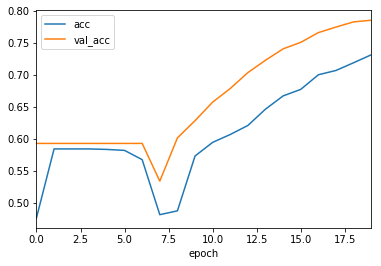

In [11]:
# plot accuracy and validation accuracy during training
df = pd.read_csv('CNN.csv', index_col='epoch')
display(df[['acc', 'val_acc']].plot())

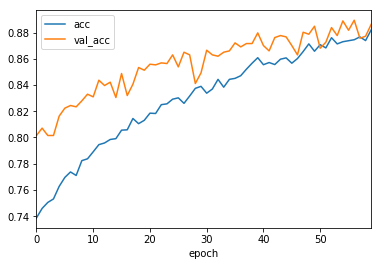

In [14]:
# plot accuracy and validation accuracy during training
df = pd.read_csv('CNN.csv', index_col='epoch')
display(df[['acc', 'val_acc']].plot())

#### Result:
Result of the first CNN model:<br> Accuracy: 88.21%, Validation Accuracy: 88.63%.

### Mimic AlexNet Model

- Next, we build this CNN model mimicing AlexNet<sup>[2]</sup>:
 - This model has 5 convolutional layers and 3 fully connected layers.
  - Normalization layer is implemented after maxpooling layer which can slove vanishing gradients and exploding gradients problems. (More spicific intro of batch normalization can refer to this <a href = "https://standardfrancis.wordpress.com/2015/04/16/batch-normalization/" target="_blank">blog</a>. 
  - At last: use softmax to classify which type each vehicle belongs to.

In [5]:
# Data Preprocessing
X_list = []
for filename in sorted(os.listdir('./Dataset_Resize/')):
    # load image data
    img = image.load_img(Path('./Dataset_Resize/', filename), target_size = (64,64)) 
    X_list.append(image.img_to_array(img))
X = np.array(X_list) # convert image to nparray

df = pd.read_csv('./vehicles.csv', index_col=0) # load annotation file
df_dummy = pd.get_dummies(df['Vehicle_Type']) # dummy encoding
Y = np.array(df_dummy)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2) # splite data for train and test

In [6]:
def AlexNet(input_shape):
    model = Sequential()
    # model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu', padding='same', input_shape=input_shape))
    # for original Alexnet
    model.add(Conv2D(96, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    # Local Response normalization for Original Alexnet
    model.add(BatchNormalization())

    model.add(Conv2D(256, (5,5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(384, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(384, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
    model.add(BatchNormalization())

    # fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))
    
    # Print model summary
    model.summary()

    # Loss function and Optimizer
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model;

In [7]:
# use callback methods the same as the baseline model above
early_Stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=0, 
    mode='auto'
)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_lr=0)
checkpointer = ModelCheckpoint(filepath="AlexNet_1.hdf5", verbose=1, save_best_only = True)
csv = CSVLogger('AlexNet_1.csv')

In [ ]:
model_Alex = AlexNet((64,64,3))
# train the model
history = model_Alex.fit(X_train, Y_train,
                       batch_size=256,
                       epochs=100,
                       verbose=1,
                       validation_data=(X_test, Y_test),
                       shuffle=True,
                       callbacks=[early_Stopping,reduceLR,checkpointer,csv])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 96)        2688      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 384)         885120    
__________

### --> Because it takes much time to retrain this model in this blog, you can get All Train Result: [AlexNet Model](./Alexnet/Mimick_AlexNet_Keras.ipynb) 

#### Result:
Result of this CNN model:<br> Accuracy: 98%, Validation Accuracy: 90.96% <br>
The accuracy is better than the baseline model.

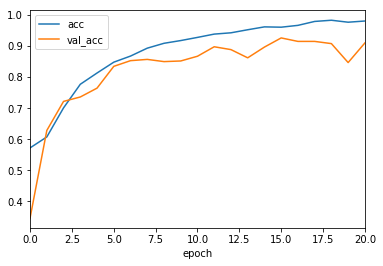

In [5]:
# plot accuracy and validation accuracy during training
df = pd.read_csv('./Alexnet/AlexNet.csv', index_col='epoch')
display(df[['acc', 'val_acc']].plot())

### Transfer Learning using Inception V3

Transfer learning is the process of taking a pre-trained model (the weights and parameters of a network that has been trained on a large dataset) with our own dataset. The idea is that this pre-trained model will act as a feature extractor. We will remove the top layers of the network and replace it with our own classifier.

In [15]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adadelta, Adam

#### Data Preprocessing: Load resized 299x299 image data and convert them to numpy array.

In [18]:
# Load saved X_train and X_test data if exist.
if os.path.exists('./Inceptionv3_TL/X_train_Inception.npz' and './Inceptionv3_TL/X_test_Inception.npz'):
    X_train = np.load('./Inceptionv3_TL/X_train_Inception.npz')['features']
    X_test = np.load('./Inceptionv3_TL/X_test_Inception.npz')['features']
    print("X")

# Load saved Y_train and Y_test data if exist.
if os.path.exists('./Inceptionv3_TL/Y_train_Inception.npz' and './Inceptionv3_TL/Y_test_Inception.npz'):
    Y_train = np.load('./Inceptionv3_TL/Y_train_Inception.npz')['features']  
    Y_test = np.load('./Inceptionv3_TL/Y_test_Inception.npz')['features']
    print("Y")
else:
    print("Y Not exists.")
    # Load image and label information and convert them to numpy array
    X_list = []
    for filename in sorted(os.listdir('./Dataset_Resize/')):
        img = image.load_img(Path('./Dataset_Resize/', filename))
        X_list.append(image.img_to_array(img))
    X = np.array(X_list)
    print(X.shape)

    df = pd.read_csv('./vehicles.csv', index_col=0)
    df_dummy = pd.get_dummies(df['Vehicle_Type'])
    Y = np.array(df_dummy)
    print(Y.shape)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Y


<p>Download InceptionV3 pretrained model on ImageNet.</p>
![Inception V3 Transfer Learning](./image/InceptionV3.png)
<p><b>Data Augmentation</b>: rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process, so we target values between 0 and 1 instead by scaling with a 1./255 factor.</p>

In [19]:
# rescale data to 0-1
datagen = ImageDataGenerator(rescale=1. / 255)

# load InceptionV3 model without top layers
model_Inception = InceptionV3(include_top = False, weights = 'imagenet')

<p>we only instantiate the convolutional part of the model, everything up to the fully-connected layers. Then, we run this model on our training and test data once, extracting the "bottleneck features" from InceptionV3 model in two numpy arrays. Then we will train a small fully-connected model on top of the stored features.</p>

<p>The reason why we are storing the features offline rather than adding our fully-connected model directly on top of a frozen convolutional base and running the whole thing, is computational effiency<sup>[3]</sup>.</p>

In [20]:
if os.path.exists('./Inceptionv3_TL/inception_features_train.npz'):
    # Load bottleneck features if exists:
    bottleneck_features_train = np.load('./Inceptionv3_TL/inception_features_train.npz')['features']
    print("done")
else:
    # Takes numpy data & label arrays, and generates batches of augmented/normalized data:
    generator = datagen.flow(X_train, Y_train, 
                     batch_size = 256)
    
    # Extract prediction features:
    bottleneck_features_train = model_Inception.predict_generator(generator)
    print("Calculate train features")
    # Save bottleneck features:
    np.savez('./Inceptionv3_TL/inception_features_train', features=bottleneck_features_train)
    print("Saved train features")

done


In [21]:
if os.path.exists('./Inceptionv3_TL/inception_features_validation.npz'):
    # Load bottleneck features if exists:
    bottleneck_features_test = np.load('./Inceptionv3_TL/inception_features_validation.npz')['features']
    print("done")
else:
    # Takes numpy data & label arrays, and generates batches of augmented/normalized data:
    generator = datagen.flow(X_test, Y_test, 
                     batch_size = 256)
    
     # Extract prediction features:
    bottleneck_features_test = model_Inception.predict_generator(generator)
    print("Calculate test features")
    # Save bottleneck features:
    np.savez('./Inceptionv3_TL/inception_features_validation', features=bottleneck_features_validation)
    print("Saved test features")

done


In [22]:
# use callback methods the same as the baseline model above
early_Stopping = EarlyStopping(
                    monitor='val_loss', 
                    patience=5, 
                    verbose=0, 
                    mode='auto')

reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_lr=0)

checkpointer = ModelCheckpoint(filepath="TL_InceptionV3.hdf5", verbose=0, save_best_only = True)

csv = CSVLogger('TL_InceptionV3.csv')

In [23]:
def get_model_TL():
    # fully connected layers:
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape = bottleneck_features_train.shape[1:]))
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))
    
    # display model summary:
    model.summary()
    
    # Loss method, optimizer and evaluation method:
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
    model.compile(loss='categorical_crossentropy',
                  optimizer= opt,
                  metrics=['accuracy'])
    return model;

In [ ]:
model_TL = get_model_TL()
# train the simple model:
history_2 = model_TL.fit(bottleneck_features_train, Y_train,
                   batch_size=256,
                   epochs=100,
                   verbose=1,
                   validation_data=(bottleneck_features_test, Y_test),
                   shuffle=True,
                   callbacks=[early_Stopping,reduceLR,checkpointer,csv])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 6150      
Total params: 2,104,326
Trainable params: 2,104,326
Non-trainable params: 0
_________________________________________________________________
Train on 7880 samples, validate on 1970 samples
Epoch 1/100
7880/7880 [==============================] - 331s 42ms/step - loss: 1.4650 - acc: 0.5522 - val_loss: 1.3511 - val_acc: 0.5858
Epoch 2/100
7880/7880 [==============================] - 122s 15ms/step - loss

### --> Because it takes much time to retrain this model in this blog, you can get All Train Result: [InceptionV3 Transfer Learning](./Inceptionv3_TL/InceptionV3_Transfer_Learning.ipynb)

#### Result:
<p>Result of this Transfer Learning:<br> Accuracy: 58%, Validation Accuracy: 60% </p> This is not a good result.

## Conclusion

- Result Summary:
    - VGG16-like Baseline Model:<br>
        image size: 32x32 Accuracy 88.21%, Validation Accuracy 88.63%
    - Mimic AlexNet Model:<br>
        image size: 64x64 Accuracy 98%, Validation Accuracy 91%
    - Transfer Learning with Inception V3:<br>
        image size: 299x299 Accuracy 58% Validation Accuracy 60%

- Based on the results generated by the above three models:<br> 
    - Mimic AlexNet has the best performance with validation accuracy higher than 0.9.
    - Concerning about relative low validation accuracy performed by Inception V3 Model, it could be the situation that this dataset does not share too much common with ImageNet where Inception V3 model has been trained and also we doubt the performance when such large and complex networks is performed on small sized images.
    - Next Step: We will try to utilize more aggressive data augmentation methods and modified dropout layer parameters with pre-trained model to train this dataset again.

## Reference

[1] https://keras.io/getting-started/sequential-model-guide/#examples<br>
[2] https://github.com/jkh911208/cswithjames/blob/master/8_CIFAR10_alexnet.py<br>
[3] https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html<br>
[4] https://github.com/alexisbcook/keras_transfer_cifar10/blob/master/Keras_Transfer_CIFAR10.ipynb

## License

#### The text in the document by Junhan Ma, Bo Han is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/
#### The code in the document by Junhan Ma, Bo Han is licensed under the MIT License https://opensource.org/licenses/MIT